In [1]:
import os 
import allel
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

In [2]:
cd ../

/Users/anushasubramanian


In [3]:
cd Desktop/Research/UCLA/tsv

/Users/anushasubramanian/Desktop/Research/UCLA/tsv


In [4]:
len(os.listdir())

7704

In [5]:
f = pd.read_csv('/Users/anushasubramanian/Desktop/Research/UCLA/yeast_parent_vcf/sgs1_as_csv.csv')
sgs1 = pd.DataFrame(f)
keys = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII","chrIX","chrX",
        "chrXI","chrXII","chrXIII","chrXIV", "chrXV","chrXVI","chrM"]
sgs1PosDict = dict.fromkeys(keys)

In [6]:
for k in sgs1PosDict:
            sgs1PosDict[k] = list(sgs1.loc[sgs1["CHROM"] == k]["POS"])

In [7]:
sgs1PosDict["chrIV"][-1]

1525226

In [8]:
chrIVPos = dict.fromkeys(list(sgs1PosDict["chrIV"]), 0) #heterozygous positions onl

In [9]:
chrIVCoverage = dict.fromkeys(list(sgs1PosDict["chrIV"]), 0) #total reads

In [10]:
for file in os.listdir():
    if file.find(".tsv") != -1:
        data = pd.read_csv( file, sep = '\t')
        chrIV = data.loc[data["#CHROM"] == "chrIV"] # all chrIV only
        chrIV.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT','psl5',
       'psl2','yi283']
        

        
        for pos in chrIV["POS"]:
            if pos not in sgs1PosDict["chrIV"]:
                chrIV.drop(chrIV.loc[chrIV["POS"] == pos].index, inplace = True)
                
                
        ref = []
        alt = []
        all_ref = []
        all_alt = []

        error = []
        for item in chrIV["yi283"]:
            reads = item.split(sep = ':')[1:3]
            if len(reads) == 2:
                for read in reads: 
                    tokens = read.split(sep = ',')
                    ref.append(tokens[0])
                    alt.append(tokens[1])
                all_ref.append([int(x) for x in ref])
                all_alt.append([int(x) for x in alt])
                ref = []
                alt = []   
            else:
                error.append(item)
                
        sum_ref = []
        sum_alt = []

        for ref in all_ref:
            sum_ref.append(sum(ref))
        for alt in all_alt:
            sum_alt.append(sum(alt))
            

        # finding the total number of reads by summing all ref and alts
        zipped = zip(sum_ref, sum_alt)
        tot_reads = [x+y for (x,y) in zipped]
        
        cleaned_chrIV = pd.DataFrame()
        cleaned_chrIV["CHROM"] = chrIV["CHROM"]
        cleaned_chrIV["POS"] = chrIV["POS"]
        cleaned_chrIV["total reads"] = tot_reads
        cleaned_chrIV["ref reads"] = all_ref
        cleaned_chrIV["alt reads"] = all_alt
        cleaned_chrIV["sum_ref"] = sum_ref
        cleaned_chrIV["sum_alt"] = sum_alt
        
        
        refPer = []
        altPer = []

        for ref, reads in zip(sum_ref, tot_reads):
            refPer.append((ref/reads)*100)
        for alt, reads in zip(sum_alt, tot_reads):
            altPer.append((alt/reads)*100)

        cleaned_chrIV["%ref"] = refPer
        cleaned_chrIV["%alt"] = altPer
        
        e = False
        for alt in altPer:
            if alt!=0 and alt!=100:
                e = True
        #print(e)

        #reset the index so we can access multiple columns of df
        cleaned_chrIV.reset_index(drop = True, inplace=True)
        
        # final is ONLY heterozygous positions for one single-cell
        final = cleaned_chrIV.loc[(cleaned_chrIV["%ref"] != 0) & (cleaned_chrIV["%ref"] != 100)]
        for pos in final["POS"]:
            if pos in chrIVPos.keys():
                chrIVPos[pos] += 1
                
        for ind in final.index:
            if final["POS"][ind] in chrIVCoverage.keys():
                chrIVCoverage[final["POS"][ind]] += final["total reads"][ind]


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Remember not to use cleaned_chrIV or final for any analysis because they change with every iteration of the for loop.

In [15]:
# only heterozygous positions 
df = pd.DataFrame()
df["POS"] = chrIVPos.keys()
df["frequency of heterozygosity"] = chrIVPos.values()
df["total reads"] = chrIVCoverage.values()

In [16]:
#df.to_csv('/Users/anushasubramanian/Desktop/# of times each position is hetero in ChrIV.csv', index = False)

In [17]:
len(df)

6741

In [18]:
df.head()

,POS,frequency of heterozygosity,total reads
0,1647,17,133
1,1875,10,60
2,1993,1,7
3,2002,1,7
4,2256,2,17


## HISTOGRAM DISTRIBUTION OF HETEROZYGOSITY

In [14]:
# HISTOGRAM
# sns.set(rc={'figure.figsize':(20,8.27)})
# sns.set(style="ticks", context="talk")

# sns.distplot(df["frequency of heterozygosity"], bins = 100, color = "purple", kde = False)

# plt.title("How many times each position in chrIV of sgs1 is heterozygous in chrIV of 7704 single cells");
# plt.xlabel("# of times a snp is represented")
# plt.ylabel("# of snps")
#plt.savefig('/Users/anushasubramanian/Desktop/ChrIV hetero distribution.png', dpi = 180, bbox_inches='tight')

## HOW MANY TIMES EACH POSITION IS HETEROZYGOUS

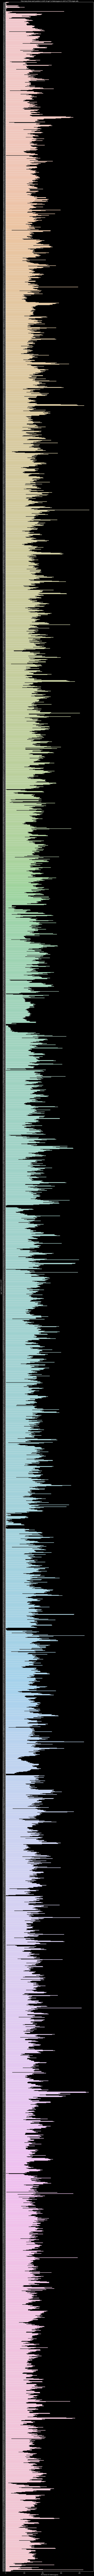

In [16]:
# BARCHART
sns.set(rc={'figure.figsize':(20,600)})
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')
sns.barplot(y = "POS",
                   x = "frequency of heterozygosity",
                   data = df, orient = 'h'
             )
plt.yticks(size = 8)


plt.title("How many times each position in chrIV of sgs1 is heterozygous in chrIV of 7704 single cells");
plt.xlabel("# of times it's heterozygous")
plt.ylabel("sgs1 positions on chrIV")
plt.savefig('/Users/anushasubramanian/Desktop/chrIV bar chart freq of hetero.png', bbox_inches='tight')

In [17]:
sorted_df = df.sort_values(by = "frequency of heterozygosity", ascending = False)[:20]

,POS,frequency of heterozygosity,total reads
1332,235902,453,4114
5483,1308583,450,3180
5484,1308589,435,3057
5482,1308573,433,3101
4285,901107,427,4326
1058,185704,425,3828
4564,973026,424,3271
6736,1524779,420,2675
5262,1271068,411,4164
5025,1189130,403,3517


In [ ]:
sorted_df.to_csv('/Users/anushasubramanian/Desktop/Top 20 overrepresented heterozygous positions.csv')

In [13]:
df.head()

,POS,frequency of heterozygosity,total reads
0,1647,17,133
1,1875,10,60
2,1993,1,7
3,2002,1,7
4,2256,2,17


## PLOT COVERAGE RATE OF HETEROZYGOUS POSITIONS

In [ ]:
# BARCHART
sns.set(rc={'figure.figsize':(20,600)})
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')
sns.barplot(y = "POS",
                   x = "total reads",
                   data = df, orient = 'h'
             )
plt.yticks(size = 8)


plt.title("Total # of reads per position");
plt.xlabel("# of reads")
plt.ylabel("sgs1 positions on chrIV")
plt.savefig('/Users/anushasubramanian/Desktop/chrIV coverage plot.png', bbox_inches='tight')